In [77]:
import nibabel as ni
import glob


In [78]:
def get_files(path):
    ##Getting all nii.gz and png files in a 2 fold directory
    folders = glob.glob(path+"/*")
    all_nii = []
    all_png = []
    for fold in folders:
        temp_nii = glob.glob(fold+"/*.nii.gz")
        temp_png = glob.glob(fold+"/*.png")
        if len(temp_nii) != 0:
            all_nii += temp_nii
        if len(temp_png) != 0:
            all_png += temp_png
    return all_png, all_nii

path = '/home/naylor/Bureau/ToAnnotate'
png, nii = get_files(path) 

In [114]:
from sklearn.cross_validation import KFold
import random
import numpy as np
from scipy import misc
import pdb

class DataManager(object):
    def __init__(self, path, name = "optionnal"):
        
        self.path = path
        self.name = name
        
    def TrainingIterator(self, fold, transforms = None):
        try:
            train_paths, test_paths = self.ValScheme[fold]
        except:
            self.prepare_sets()
            train_paths, test_paths = self.ValScheme[fold]
        if transforms is None:
            for path_nii in np.array(self.nii)[train_paths]:
                yield self.LoadGTAndImage(path_nii)
        else:
            for path_nii in np.array(self.nii)[train_paths]:
                img, img_gt = self.LoadGTAndImage(path_nii)
                for f in transforms:
                    yield f._apply_(img), f._apply_(img_gt)
        
        
    def get_files(self, path):
        ##Getting all nii.gz and png files in a 2 fold directory
        folders = glob.glob(path+"/*")
        all_nii = []
        all_png = []
        for fold in folders:
            temp_nii = glob.glob(fold+"/*.nii.gz")
            temp_png = glob.glob(fold+"/*.png")
            if len(temp_nii) != 0:
                all_nii += temp_nii
            if len(temp_png) != 0:
                all_png += temp_png
        return all_png, all_nii
    
    def prepare_sets(self, leave_out = 2, folds = 3):
        dic = {}
        try:
            n = len(self.nii)
        except:
            self.png, self.nii = self.get_files(self.path)
            n = len(self.nii)
        
        dic['score_set'] = random.sample(range(n),leave_out)
        new_list = np.array([i for i in range(n) if i not in dic['score_set']])
        n_prime = len(new_list)
        kf = KFold(n_prime, n_folds = folds, shuffle = True, random_state= None)
        j = 0
        for train_index, test_index in kf:
            dic[j] = (new_list[train_index], new_list[test_index])
            j += 1
        self.ValScheme = dic 

    def SetTransformation(self, list_object):
        self.transfoms = list_object
            
        
    def LoadGTAndImage(self, path):
        ## you give the ground truth path
        try:
            num = path.split('/')[-1].split('.')[0]
            path_image = [el for el in self.png if num in el.split('/')[-1]][0]
        except:
            self.png, self.nii = self.get_files(self.path)
            num = path.split('/')[-1].split('.')[0]
            path_image = [el for el in self.png if num in el.split('/')[-1]][0]
        
        image = self.LoadImage(path_image)
        image_gt = self.LoadGT(path)
        return image, image_gt
        
    def LoadGT(self,path):
        image = ni.load(path)
        return image.get_data()[:,:,0]
    
    def LoadImage(self, path):
        image = misc.imread(path)
        return image

    

In [7]:
png

['/home/naylor/Bureau/ToAnnotate/Slide_162438/25.png',
 '/home/naylor/Bureau/ToAnnotate/Slide_162438/63.png',
 '/home/naylor/Bureau/ToAnnotate/Slide_162438/58.png',
 '/home/naylor/Bureau/ToAnnotate/Autre/383.png',
 '/home/naylor/Bureau/ToAnnotate/Autre/209.png',
 '/home/naylor/Bureau/ToAnnotate/Slide_160120/160.png',
 '/home/naylor/Bureau/ToAnnotate/Slide_160120/152.png',
 '/home/naylor/Bureau/ToAnnotate/Slide_160120/16.png',
 '/home/naylor/Bureau/ToAnnotate/Slide_141549/283.png',
 '/home/naylor/Bureau/ToAnnotate/Slide_141549/367.png',
 '/home/naylor/Bureau/ToAnnotate/Slide_141549/83.png']

In [115]:
test = DataManager(path)
test.prepare_sets()


In [96]:
path

'/home/naylor/Bureau/ToAnnotate'

In [65]:
image = ni.load(test.nii[0])
data = np.zeros(shape = image.shape)

In [76]:
plt.imshow(image.get_data()[:,:,0])
plt.show()
image.get_data()[:,:,0].shape

(512, 512)

In [83]:
%matplotlib inline
### Useful plotting function
def plot_comparison(original, modified, modification):

    fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=(16,16), sharex=True,
                                   sharey=True)
    ax1.imshow(original, cmap=plt.cm.gray)
    ax1.set_title('original')
    ax1.axis('off')
    ax1.set_adjustable('box-forced')
    ax2.imshow(modified, cmap=plt.cm.gray)
    ax2.set_title(modification)
    ax2.axis('off')
    ax2.set_adjustable('box-forced')

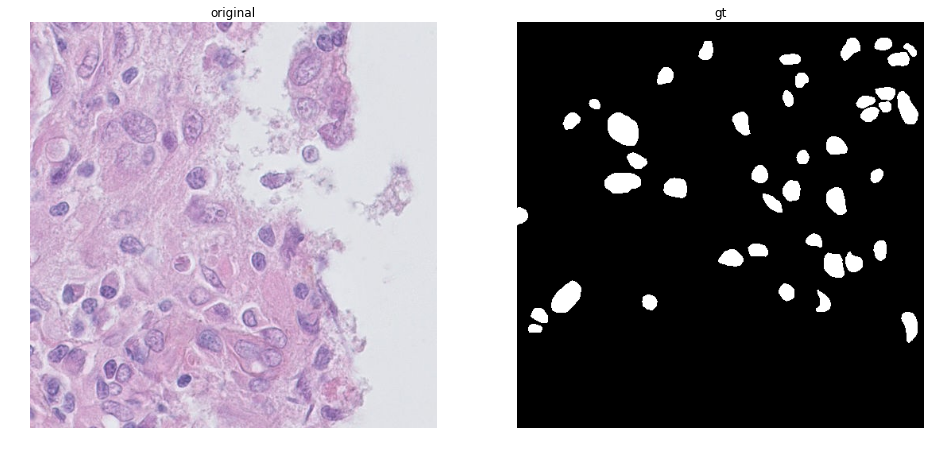

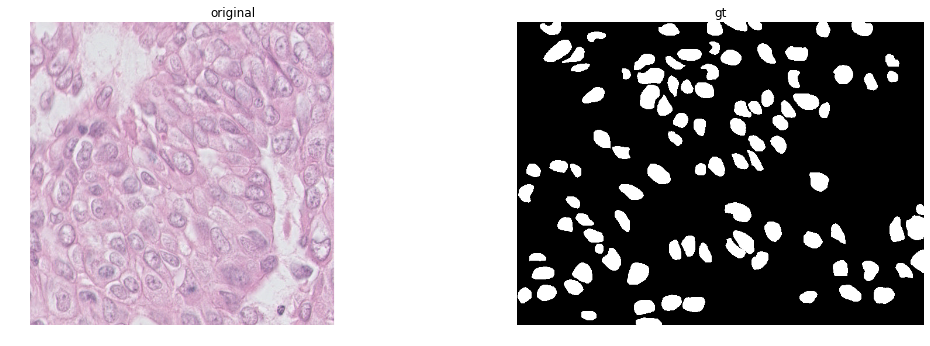

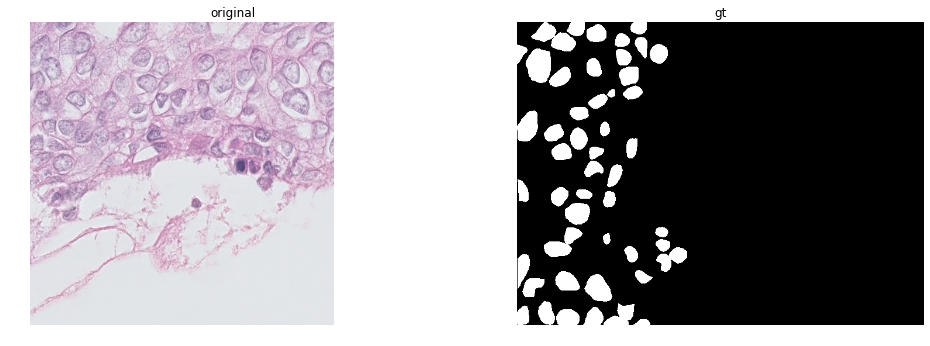

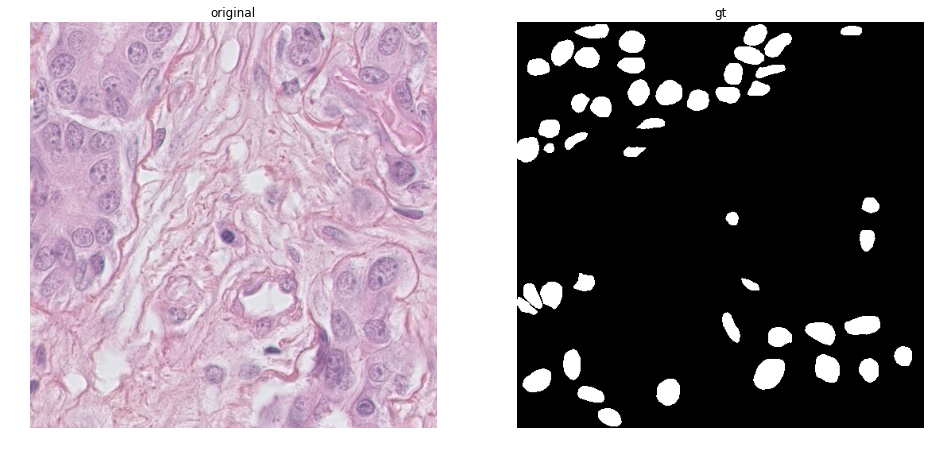

In [116]:
for img, img_gt in test.TrainingIterator(fold = 1):
    plot_comparison(img, img_gt, "gt")